# Project Report

Benjamin Mottis, Elie Chelly, Maxime Rombach, Salim Ben Ghorbel

Since we were not able to meet during this project due to the current situation, we decided to have the most easily replicable environement possible. This is why we went for an A0 (approximately) format piece of paper with printed black polygonal obstacles and a red circle as our goal. \
\
The choice we made was the following: no need to fix a camera or any consquent installation as such. This is why we are using a piece of code that detects the contous of our map and projects it flat. The camera we are using is the one from our smartphone, thanks to an ip based webcam app. After the projection step, we can easily detect our robot, its orientation, our obstacles and the goal. Then, based on the obstacles (simple polygons), we can build a visibility graph and apply an A star algorithme to find a path.\
\
We are concious of some weaknesses of our code. For example, a more optimised curved path exists. This implies that the movements of our robot are decomposed in two phases: orientation and advancing. Our vision module is environement dependant and can give random results when the contrasts is weak. We also had some troubles with clearly defining the edges of our map so if an obstacle is to close to the border, our robot may navigate outside of the perimeter.

This a picture of our environement:
<br/>

![Pentagon](media/thymio_square3.jpg)

<br/>

The following installs will be needed to run the code.

In [ ]:
!pip install opencv-python matplotlib numpy
!pip install pyvisgraph
!pip install imutils
!pip install scikit-image

## Chapter 1: Extracting information from an image

All of our dimensions are in meter and our images in RGB.

In [1]:
import cv2
import matplotlib.pyplot as plt
from vision import vision
'''
    This class contains the required methods for the vision module, including:
        * detecting the map and warp perspective to rectangular shape.
        * locating thymio orientation and position based off feature points.
        * locating target point.
        * extracting obstacles and extending them with thymio clearance.
    This class relies on a multitude of computer vision techniques and performs
    heavy targeted filtering steps to extract precise information from camera 
    pictures.
    Filters used by this class are: thresholding, canny, dilation, erosion,
    opening, closing, color filtering, gaussian blurr, etc.
    '''
import imutils
import global_navigation
import utilities

map_x = 0.89 # in meters
map_y = 0.84 # in meters
thymio_clearance_m = 0.12 # in meters

### Section a: Capturing the image and projecting it

The first step of our alogrithm consists in the capture of an image of our terrain. In our code, all of our vision functions are methods of the class vision that we defined. This is what a picture of the map looks like.\

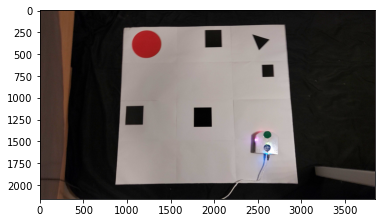

In [2]:
filename = 'media/saved_img2.png'
image = cv2.imread(filename, cv2.IMREAD_COLOR)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)

The warp_map method then detects the edges of our map and projects it. This is done using a canny filter preceded by a gaussian blurr. We then use the findContours function from cv2.

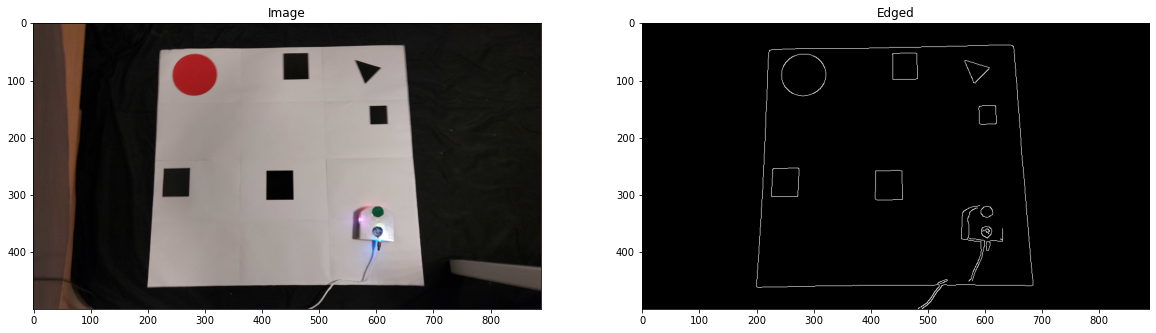

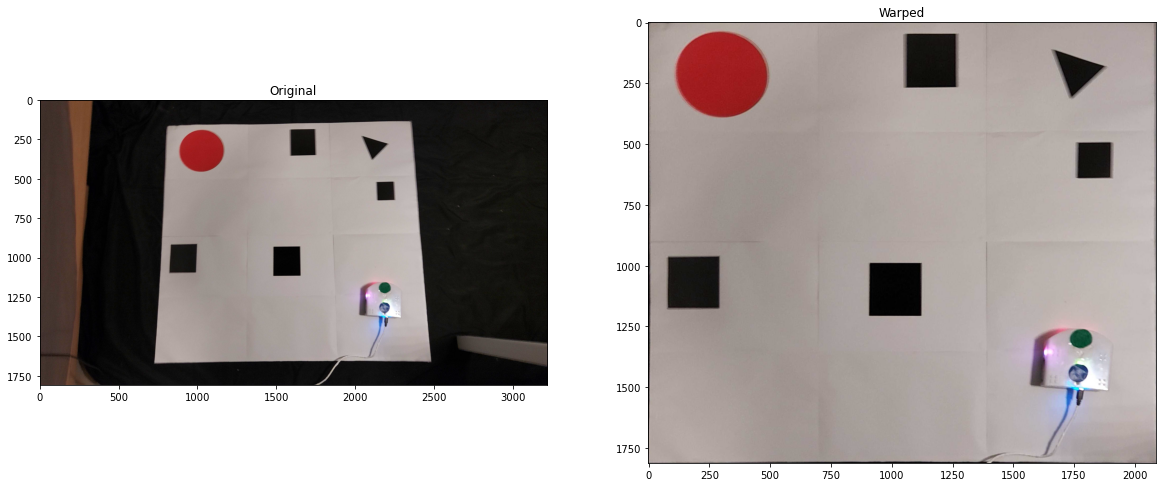

In [3]:
vis = vision(0, plot=True)

'''
        cr: https://medium.com/@evergreenllc2020/building-document-scanner-with-opencv-and-python-2306ee65c3db
        This method takes as input an image of a map taken from a random angle,
        detects the rectangular shape of the map and returns a rectangular image
        containing only the map.
        '''
warped = vis.warp_map(image)

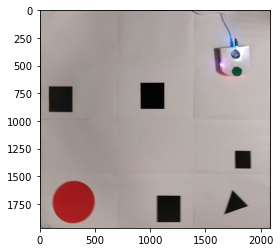

In [4]:
warped = cv2.flip(warped, 0)
warped, scaling_px_2_m = vis.scale_map(warped, map_x, map_y)
plt.imshow(warped)

### Section b: Locating the thymio and its orientation and finding the goal

To locate the thymio and its orientation we tried out different methods, such as using the ORB machine learning algorithme in cv2. This algorithme is described in details in a paper written by Ethan Rublee, Vincent Rabaud, Kurt Konolige, Gary R. Bradski: ORB: An efficient alternative to SIFT or SURF. ICCV 2011: 2564-2571.\
We found out that we could get similar (or sometimes better) results with simple shapes and simple colour filters to locate our feature images.

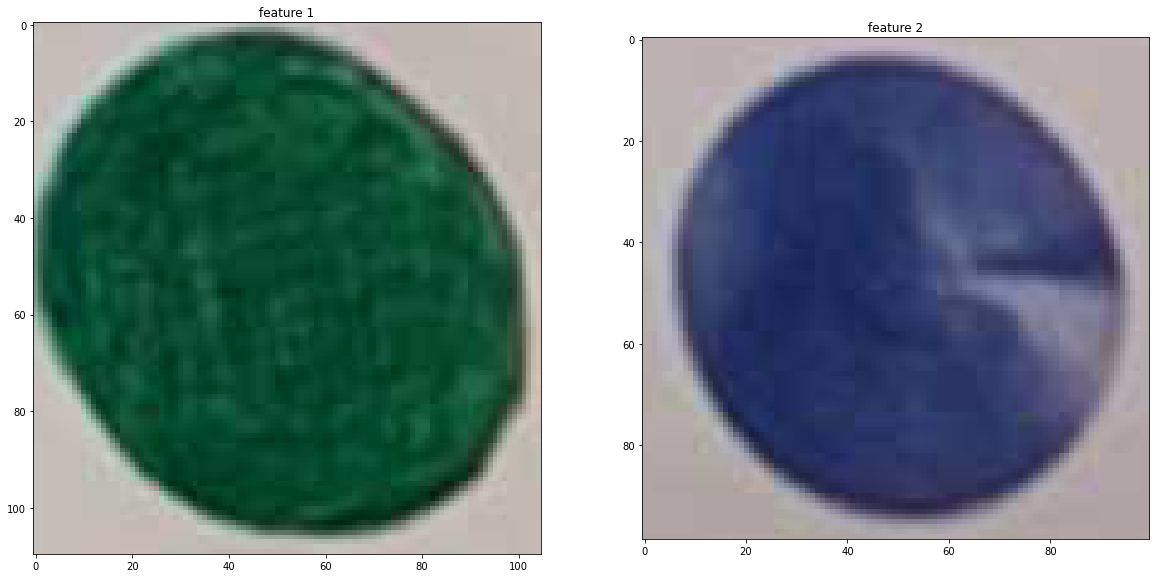

In [5]:
# Load the feature images
feature_image_1 = cv2.imread('media/thymio_circle_green.png')
feature_image_2 = cv2.imread('media/thymio_circle_blue.png')
# Convert the features images to RGB
feature_image_1 = cv2.cvtColor(feature_image_1, cv2.COLOR_BGR2RGB)
feature_image_2 = cv2.cvtColor(feature_image_2, cv2.COLOR_BGR2RGB)

# feature_color_2 = [72, 96, 46]
feature_color_1 = [8, 72, 47]
feature_color_2 = [39, 52, 104]

fx, plots = plt.subplots(1, 2, figsize=(20,10))
plots[0].set_title("feature 1")
plots[0].imshow(feature_image_1)
plots[1].set_title("feature 2")
plots[1].imshow(feature_image_2)

The following piece of code detects the feature image simply with coulour filters and calculates the center of the thymio. This allows the extraction of the x, y and theta (orientation of the robot).

From locate feature [1777.23589648  552.78663191]
From locate feature [1770.34580567  396.55763428]
[1777.23589648  552.78663191] [1770.34580567  396.55763428]


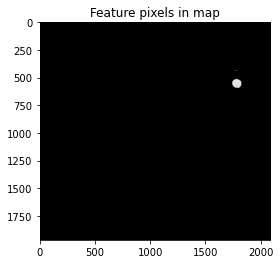

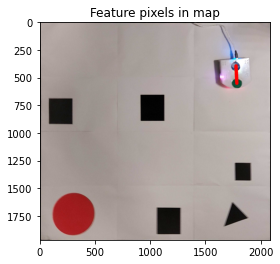

In [6]:
thymio_x_m, thymio_y_m, thymio_theta_rad = vis.locate_thymio(warped, feature_image_1, feature_color_1, feature_image_2, feature_color_2, scaling_px_2_m)

The target can easily be located thanks to its red colour with a simple colour filter.

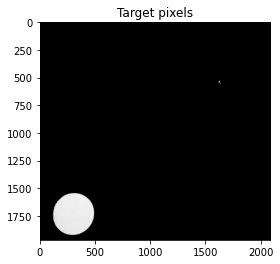

In [7]:
target_color = [148, 18, 28]
target_position_px = vis.locate_target_px(warped, target_color)
target_position_m = target_position_px * scaling_px_2_m

## Chapter 2: Finding a path from the start to the goal

### Section a: Building the obstacle map and extracting the obstacles vertices

Now that the thymio and the target has been located, we can take care of the obstacle map.

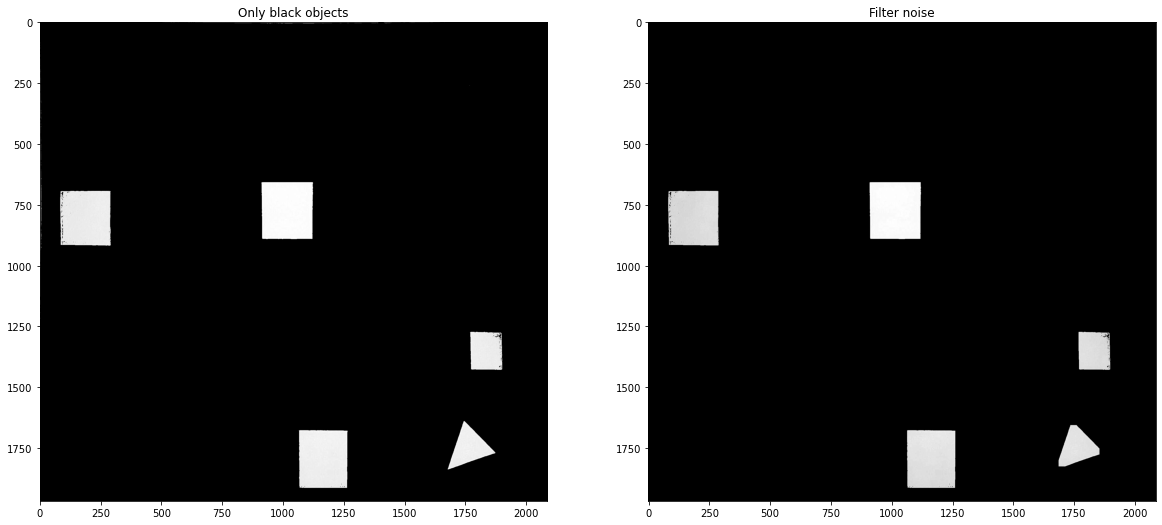

In [8]:
'''
        This method takes as input an image of the warped map and filters it
        in such a way that it extracts the obstacles and the free parts of the
        map. In the input, obstacles are dark and the map is bright. For the 
        output, the obstacles are white pixels.

        Parameters
        ----------
        warped : image
            Warped image of the map.

        Returns
        -------
        obstacle_map : image
            A black and white image with obstacles as white.

        '''
obstacle_map = vis.create_obstacle_map(warped)

The thymio clearence_px variable is used to dilate the obstacles so that the robot takes in account its size when planning its path.

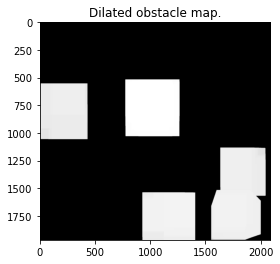

In [9]:
thymio_clearance_px = int(thymio_clearance_m / scaling_px_2_m)
'''
        This method performs morphological dilation to obstacle map such that
        it takes nto account the thymio clearance.

        Parameters
        ----------
        obstacle_map : image
            black and white obstacle image.
        thymio_clearance_px : integer
            Amount of pixels for the obstacles to be dilated by.

        Returns
        -------
        dilated_obstacle_map : image
            Dilated obstacle map.

        '''
dilated_obstacle_map = vis.dilate_obstacle_map(obstacle_map, thymio_clearance_px)

A clean image of the obstacles allows the detection of all obstacle verticies and the grouping of them by polygon. The following code is an adaptation of a code we found on https://www.geeksforgeeks.org/find-co-ordinates-of-contours-using-opencv-python/. In addition to finding the obstacles verticies and grouping them by obstacle, it does so in a counter clockwise way, starting by the top-left most point of the polygone. Therefore the array returned is ordered. The parameter scaling_px_2_m converts the coodonates from pixels to meters.

In [10]:
'''
This method takes as input a grayscale image with polygon obstacles such that
        bright pixels are obstacles and dark obstacle are free and returns the 
        coordinates of obstacle vertices in an array.
        cr https://www.geeksforgeeks.org/find-co-ordinates-of-contours-using-opencv-python/
'''
vertices_array = vis.get_obstacle_vertices(dilated_obstacle_map,scaling_px_2_m)

### Section b: Using the library pyvisgraph to build the visibility graph and finding the shortest path

Now, using the pyvisgraph lybrary, a visibility graph is built. The method used by this library is an implementation of Lee's visibility graph algorithme. Its complexity is the following: $O(n^2log(n))$. The naive method would have a complexity of $O(n^3)$. This is due to the fact that for each vertex, only the visible vertices are checked. Checking only the visible vertices only takes a complexity of $O(nlog(n))$ thanks to a counter clock wise line scanning method called Lee's scan line.

Once the visibility graph is built, the lybrary uses a simple A* algorithme that returns a sequence of points defining the path of our robot.

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 37.56it/s]


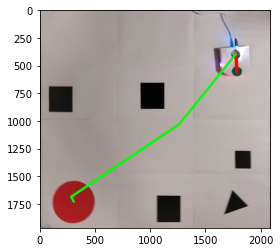

In [11]:
x_0 = thymio_x_m
y_0 = thymio_y_m 
theta_0 = thymio_theta_rad

"""
This method takes as input an array of vertices, map dimensions and thymio 
clearance to build obstacle object list which will be used with pyvisgraph API.
"""
obstacles = global_navigation.build_obstacles(vertices_array, map_x, map_y, thymio_clearance_m)
"""
This method uses pyvisgraph API to build a visibility graph which will be 
used by the A* algorithm.
"""
graph = global_navigation.build_visgraph(obstacles)
"""
This method applies the A* algorithm to find shortest path to be followed
by Thymio.
"""
sp = global_navigation.apply_astar(graph, [x_0,y_0],target_position_m)
all_target_points = []
for i in range(0,len(sp)):
    all_target_points.append([sp[i].x,sp[i].y])
    
utilities.draw_path(all_target_points, scaling_px_2_m,warped)

## Chapter 3: Navigating to the goal

In [12]:
import robot
from Thymio import Thymio
import time

#th = Thymio.serial(port="/dev/cu.usbmodem14101", refreshing_rate=0.1)
th = Thymio.serial(port="\\.\COM5", refreshing_rate=0.1)

Once the path has been created, a "my_robot" object is created from the robot class. This class contains all the methods allowing the robot to move on the plane but also all the functions related to its sensors (odometry, local avoidance with the prox sensor...). In order to initialize this object, the program takes the values of the initial state of the robot (x_0, y_0, theta_0), the list of the target points and its speed v [m/s]. the latter corresponds to the measured speed for a robot calibrated to go in a straight line with an average command of 100. The commands sent to the robot after a good calibration are 104 for the right wheel and 96 for the left wheel. 

In [13]:
v = 0.03275
my_robot = robot.robot(th,all_target_points,x_0,y_0,theta_0,v)

Once the "my_robot" object has been created, the thymio will search the first target point in the all_target_points list and then will start. A sequential strategy has been chosen, so the movement is decomposed into a rotation and then a straight line movement. This method has a very simple execution and limits inaccuracies in the measurement of positioning by odometry. It's implemented using a While loop that checks if the robot has not reached the final goal. 
As odometry does not allow to have a very good accuracy, the position and orientation of the robot is measured by vision at each target point. To prevent the robot from making a small movement to compensate the error and reposition itself on the target point,a new set of target points is calculated using the same algorithm as above. This method is not the most fluid  because it forces the robot to pause at each target point to retake a photo and calculate its new path but it allows to reach a very good precision on the position and the orientation of the robot.Thus, it reaches the goal avoiding all obstacles precisely whatever its starting point. Its arrival on the goal is only determined with the odometry because its offers enough precision since the position and orientation of the robot has been updated with the vision at the previous target point. 

In [ ]:
while my_robot.on_goal() == False:
    
    my_robot.find_next_target_point()
    my_robot.turn_to_target_point()  
    my_robot.advance_to_target_point()

    if my_robot.on_goal():
        break
    
    time.sleep(0)
    for i in range(2):
        try:
            image = vis.get_camera_image()
            warped = vis.warp_map(image)
            warped = cv2.flip(warped, 0)
            warped, scaling_px_2_m = vis.scale_map(warped, map_x, map_y)
            my_robot.x, my_robot.y, my_robot.theta = vis.locate_thymio(warped, feature_image_1, feature_color_1, feature_image_2, feature_color_2, scaling_px_2_m)
            break
        except: 
            time.sleep(3)
            pass
        
    sp = nav.apply_astar(graph, [my_robot.x,my_robot.y], target_position_m)            
    
    new_all_target_points = []
    for i in range(0,len(sp)):
            new_all_target_points.append([sp[i].x,sp[i].y])
    my_robot.all_target_points = new_all_target_points
    my_robot.target_point = [new_all_target_points[0][0],new_all_target_points[0][1]]

print ("arrived")

Exception in thread Thread-9:
Traceback (most recent call last):
  File "c:\users\maxime\appdata\local\programs\python\python37\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "c:\users\maxime\appdata\local\programs\python\python37\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\Maxime\Documents\EPFL\MA3\Basics of mobile robotics\Projet\Project\common\Thymio.py", line 340, in do_refresh
    self.get_variables()
  File "C:\Users\Maxime\Documents\EPFL\MA3\Basics of mobile robotics\Projet\Project\common\Thymio.py", line 499, in get_variables
    self.send(msg)
  File "C:\Users\Maxime\Documents\EPFL\MA3\Basics of mobile robotics\Projet\Project\common\Thymio.py", line 456, in send
    self.io.write(msg.serialize())
  File "c:\users\maxime\appdata\local\programs\python\python37\lib\site-packages\serial\serialwin32.py", line 323, in write
    raise writeTimeoutError
serial.serialutil.SerialTimeoutException: Write timeou

## Chapter 4: Local avoidance ##

At first, we wanted to try a Braitenberg approach for local avoidance. However, we quickly noticed that the resulting unpredictable behavior would complicate the localisation process. That's why we choosed to go for predifined sequences of moves, depending on where the obstacle was detected.

_Assumption_ : obstacle dimensions are similar to thymio's

__Strategy description:__

When thymio moves forward, it checks its front proximity sensors for unexpected obstacles.
The local avoidance event is triggered as soon as one of them sees something. When it occurs a predefined dodging sequence is executed by thymio. The whole local avoidance strategy is defined in the function _local_avoidance_ of the __robot__ class. Here is an example of event:

1. Saw something with left sensors
1. Trigger predifined dodging sequence to the right
1. Exit local avoidance and take a new photo for position

## Kalman filtering ##

We developped a solution to use a Kalman filter for the x,y position and speed. The idea was to use the data from the odometry and the accelerometer embedded in Thymio. It is scripted in _kalman_filtering.py_.

Unfortunately, we noticed that in did not improve the overall assumption much. So we decided to correct the position of thymio using a photo. The filtering part then occurs on the processing of the photo.

## Chapter 5: Tests and results ##

Different scenarios were tested in order to validate the program with different starting points, different barriers, and notably local barriers added during implementation. On the first picture, the path calculated by the A star algorithm is presented (in green) and, on the second picture, the path made by the robot is displayed (in blue). The robot avoided twice the cups that were added during its execution and reached the goal avoiding all the obstacles. 

<br/>

![Path planning](media/path.jpeg)

<br/>

<br/>

![Local avoid](media/local_avoid.png)

<br/>

# Videos #

We recorded some compelling videos showing global path planning and local avoidance. The reader can find them [here](https://drive.google.com/drive/folders/1r4fKE0I8ZR0N2rvhq0zXIcRtLRQ9XBUu?usp=sharing).

## Conclusion ##

The aim of this project was to create modules related to mobile robotics and interconnect them. Their combination result in the motion of thymio towards a goal, while being able to avoid unexpected obstacles. The module vision does a major part of the planning, localisation and filtering processes. The global navigation is done step by step along set points. In parallel, the local avoidance module is triggered when an obstacle is seen.

Overall this project aimed to give us an insight of the large variety of the processes involved inmobile robotics. We learned a lot in terms of technical knowledge and teamwork.